Author: Dr. Göktuğ Aşcı <br>
Creation Date: 06.06.2021 <br>
Licence: MIT license <br> 
Data: [Data set](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)

# Introduction and Imports

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).

Input variables (based on physicochemical tests):

1 - fixed acidity <br>
2 - volatile acidity <br>
3 - citric acid <br>
4 - residual sugar <br>
5 - chlorides <br>
6 - free sulfur dioxide <br>
7 - total sulfur dioxide <br>
8 - density <br>
9 - pH <br>
10 - sulphates <br>
11 - alcohol <br>

Output variable (based on sensory data): <br>

12 - quality (score between 0 and 10)

In [1]:
#Importing required packages.

import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import requests
import json

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline

import mlflow

In [2]:
#Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
#Loading dataset
df = pd.read_csv('data/winequality-red.csv')

In [5]:
#Standard random state for all operations
random_state = 42

#Log mlfow: boolean
RUN_MLFLOW = True

# 1. Exploratory Data Analysis

In [6]:
#Let's check how the data is distributed
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
#Information about the data columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [9]:
df.shape

(1599, 12)

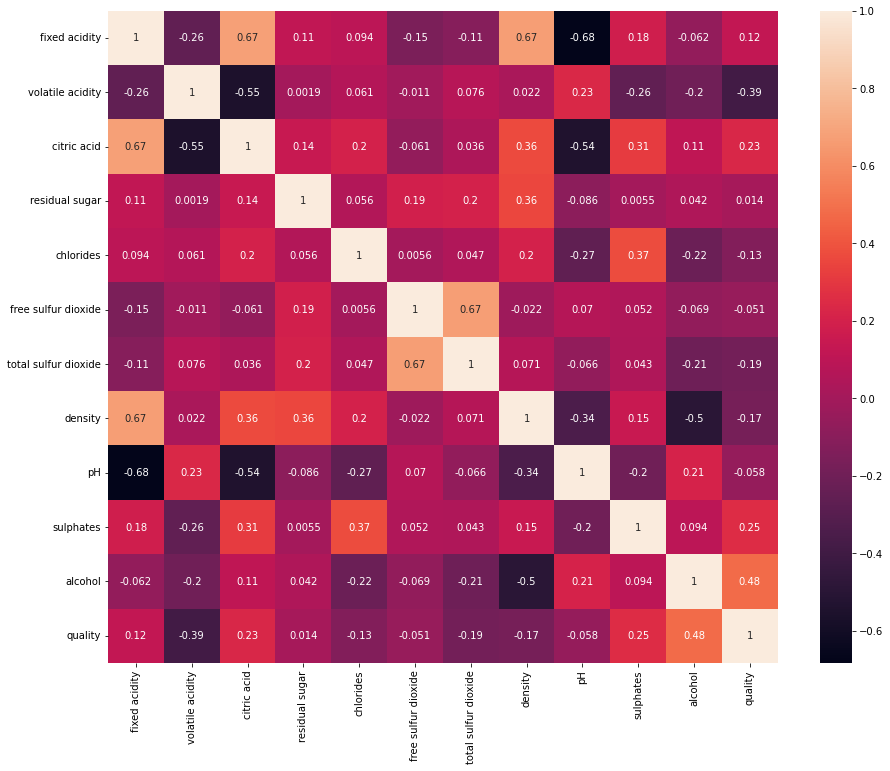

In [10]:
#Let's observe correlations between features
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True);

<AxesSubplot:xlabel='quality', ylabel='count'>

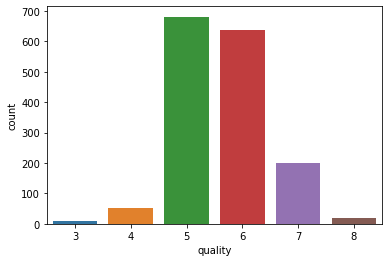

In [11]:
sns.countplot(df['quality'])

# 2. Data Preprocessing

In [12]:
def remove_outliers(df):
    #Calculate z-scores of `df`
    z_scores = stats.zscore(df)

    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    df = df[filtered_entries]
    return df

#Create a reproducible function for the input data
def apply_feature_engineering_preprocessing(df):
    
    #Making binary classificaion for the response variable.
    #Dividing wine as good and bad by giving the limit for the quality
    bins = (2, 6.5, 8)
    group_names = ['bad', 'good']
    df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)
    
    #Now lets assign a labels to our quality variable
    label_quality = LabelEncoder()
    
    #Bad becomes 0 and good becomes 1 
    df['quality'] = label_quality.fit_transform(df['quality'])
    
    df = remove_outliers(df)
    return df

In [13]:
#Apply feature engineering
df = apply_feature_engineering_preprocessing(df)

df.head(20)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0
6,7.9,0.600,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,0
7,7.3,0.650,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,1
8,7.8,0.580,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,1
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,0


In [14]:
df['quality'].value_counts()

0    1257
1     201
Name: quality, dtype: int64

<AxesSubplot:xlabel='quality', ylabel='count'>

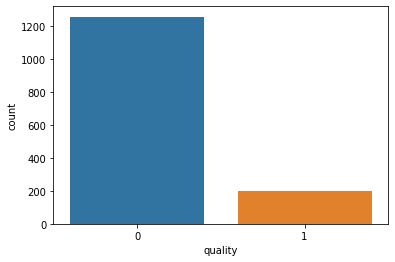

In [15]:
sns.countplot(df['quality'])

We have an unbalanced data set.

In [16]:
#Now seperate the dataset to feature and target variables
X = df.drop('quality', axis = 1)
y = df['quality']

In [17]:
#Train and test splitting of data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

# 3. Model Creation

In [18]:
#Apply preprocessing
preprocessing = ColumnTransformer([
    
    #Column dropper 
    ("column_dropper", "drop", ["residual sugar"]), 
    
], remainder="passthrough")

In [19]:
#Creating the pipeline
clf = Pipeline([
    ("preprocessing", preprocessing),
    ("scaler", StandardScaler()), # scale values before PCA
    ("pca", PCA()),
    ("classification", KNeighborsClassifier())
])

In [20]:
#Try different hyperparamaters
param_grid = [
    {   
        "pca__n_components": list(range(3, 10)),
        "classification__n_neighbors": [3, 4, 5, 6, 7, 8],
        "classification__leaf_size": [10, 20, 30, 40, 50]
    }
]

In [21]:
clf = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, scoring="accuracy", return_train_score=True, verbose=1)

### 3.1 Without mlflow

In [22]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('column_dropper',
                                                                         'drop',
                                                                         ['residual '
                                                                          'sugar'])])),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('classification',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'classification__leaf_size': [10, 20, 30, 40, 50],
                          'classification__n_neighbors': [3, 4, 5, 6, 7, 8],
                          'pca__n_components': [3, 4, 5, 6, 7, 8, 9]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [23]:
#Listing the best parameters for the param_grid:
clf.best_params_

{'classification__leaf_size': 10,
 'classification__n_neighbors': 4,
 'pca__n_components': 6}

In [24]:
#Get the best score
clf.best_score_

0.8842265507501559

In [25]:
#Store the best model in a variable
best_model = clf.best_estimator_
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('column_dropper', 'drop',
                                                  ['residual sugar'])])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=6)),
                ('classification',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=4))])

### Try on unseen data

In [26]:
#Let's use the test set to create predictions
predictions = best_model.predict(X_test)

In [27]:
#Calculating the accuracy score manually
score = accuracy_score(y_test, predictions)
score

0.8904109589041096

Since the target column is unbalanced, we should check f1 score, too.

In [28]:
score = f1_score(y_test, predictions)
score

0.3846153846153846

As expected, f1 score is much lower because our dataset is unbalanced.

In [29]:
#Creating the confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

[[250   8]
 [ 24  10]]


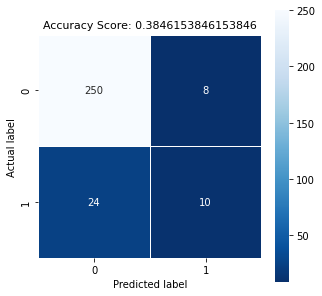

In [30]:
#Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 11);

### 3.2 With mlflow

#### 3.2.1 Train and log models using mlflow

In [31]:
class Model:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.leaf_size = 10
        self.n_jobs = -1
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test 
        
    def try_different_neighbors(self, neighbor_array):
        """
        This function tries different neighbors on the model
        """
        
        for n_neighbors in neighbor_array:
            knn = KNeighborsClassifier(leaf_size=self.leaf_size, n_neighbors=n_neighbors, n_jobs=self.n_jobs)
            knn.fit(self.X_train, self.y_train)
            
            # let's use the test set to create predictions
            predictions = knn.predict(X_test)
            
            # calculating the accuracy score manually
            accuracy = accuracy_score(y_test, predictions)
            f1 = f1_score(y_test, predictions)

            self.log_mlflow(knn, n_neighbors, accuracy, f1)
        
    def log_mlflow(self, model, n_neighbors, accuracy, f1):
        """
        This function logs model parameters and metrics to mlflow server
        """
        
        run_name = "KNN - n:{}".format(n_neighbors)
        
        with mlflow.start_run(run_name=run_name):
            mlflow.log_param("n_neighbors", n_neighbors)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score", f1)
            mlflow.sklearn.log_model(model, "model")

In [32]:
#Start logging with mlflow
if RUN_MLFLOW:
    neighbors = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    model = Model(X_train, X_test, y_train, y_test)
    model.try_different_neighbors(neighbors)

* n_neighbors = 5 is the best performing model:

![Best model](https://mealdoc-2.s3-eu-west-1.amazonaws.com/model_best.png)

#### 3.1.2 Get predictions directly from an API endpoint

First, you should run this command to start the server:

`mlflow models serve --model-uri runs:/b0ad7c70c92843c39d2eb8f2114c54b9/model --no-conda --port 1234`

In [33]:
def get_prediction_from_server(row):
    """
    This functions receives response from the machine learning server
    """
    
    row = row[:-1]
    
    data = {
        "columns":list(X_train.columns),
        "data": [row]
        }

    headers = {"Content-Type": "application/json",  "format": "pandas-split"}
    
    r = requests.post('http://127.0.0.1:1234/invocations', data=json.dumps(data), headers=headers)

    return r.json()[0]

In [34]:
#Get predictions directly from the server using the specified model
#Bad becomes 0 and good becomes 1 
print(list(X_train.columns))
for row in df.values.tolist():
    print("{}: {}".format(row, get_prediction_from_server(row)))

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4, 0.0]: 0
[7.8, 0.88, 0.0, 2.6, 0.098, 25.0, 67.0, 0.9968, 3.2, 0.68, 9.8, 0.0]: 0
[7.8, 0.76, 0.04, 2.3, 0.092, 15.0, 54.0, 0.997, 3.26, 0.65, 9.8, 0.0]: 0
[11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.998, 3.16, 0.58, 9.8, 0.0]: 0
[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4, 0.0]: 0
[7.4, 0.66, 0.0, 1.8, 0.075, 13.0, 40.0, 0.9978, 3.51, 0.56, 9.4, 0.0]: 0
[7.9, 0.6, 0.06, 1.6, 0.069, 15.0, 59.0, 0.9964, 3.3, 0.46, 9.4, 0.0]: 0
[7.3, 0.65, 0.0, 1.2, 0.065, 15.0, 21.0, 0.9946, 3.39, 0.47, 10.0, 1.0]: 0
[7.8, 0.58, 0.02, 2.0, 0.073, 9.0, 18.0, 0.9968, 3.36, 0.57, 9.5, 1.0]: 0
[7.5, 0.5, 0.36, 6.1, 0.071, 17.0, 102.0, 0.9978, 3.35, 0.8, 10.5, 0.0]: 0
[6.7, 0.58, 0.08, 1.8, 0.0969999999999999, 15.0, 65.0, 0.9959, 3.28, 0.54, 9.2, 0.0]: 0
[